# CLASIFICACIÓN DE TWETS CON LIMPIEZA

En este libro analizaremos tweets, los cuales se buscarán que sean sobre los debates de las elecciones colombianas, para ver que tipo de usuarios existen en twitter y se tratará de clasificar los comentarios.

Primero que todo obtuvimos unos cuantos twets por medio de la herramienta [twint](https://github.com/haccer/twint), con la cual podemos obtener discusiones alrededor de hashtags.

nuestro archivo se llamara output.csv.

Cargaremos el archivo con pandas

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans 
#importamos la libreria que realizara los grupos
import matplotlib.pyplot as plt
%matplotlib inline 
datos = pd.read_csv('output.csv', header = 0)

Ahora vamos a ver como se estructuran los datos

In [6]:
print(datos.ix[0:4])

                   id        date      time timezone             user_id  \
0  991850911835226112  2018-05-02  01:24:19      GMT          1713348180   
1  991768558282604545  2018-05-02  19:57:05      GMT  876316397332307968   
2  991755106751340547  2018-05-02  19:03:38      GMT          1713348180   
3  991527191681945600  2018-05-01  03:57:58      GMT           438683266   
4  991499060073914368  2018-05-01  02:06:11      GMT           138093954   

       username                                              tweet  replies  \
0    dinativa86  @MoralesViviane @IvanDuque @JulyTrsplcs @adana...        0   
1  JuanEGalvis1  A todos los colombianos y votantes, POR FAVOR ...        0   
2    dinativa86  @IvanDuque @Olgallego El mismo que en #ElPaisD...        0   
3   Lorenssssss  #YoVotoFajardo Por un país ni de izquierda ni ...        0   
4         mmpa9  @Colcheck tienen el chequeo de las respuestas ...        0   

   retweets  likes  location                                        

Aqui podemos ver todos los atributos, de los cuales solo nos importan los twets

In [8]:
tweets = datos['tweet']
print(tweets.ix[0:5])
#tweets = list(tweets.ix[0:2999])
print(len(tweets))


#reviso el tipo de dato de un tweet
print(type(tweets[0]))

0    @MoralesViviane @IvanDuque @JulyTrsplcs @adana...
1    A todos los colombianos y votantes, POR FAVOR ...
2    @IvanDuque @Olgallego El mismo que en #ElPaisD...
3    #YoVotoFajardo Por un país ni de izquierda ni ...
4    @Colcheck tienen el chequeo de las respuestas ...
5    Por diferente que sea tu opinión, por pequeño ...
Name: tweet, dtype: object
3660
<class 'str'>


In [9]:
import spacy
print(tweets[0])
print(tweets[1])
nlp = spacy.load('es')

doc1 = nlp(tweets[0])
doc2 = nlp(tweets[1])

@MoralesViviane @IvanDuque @JulyTrsplcs @adanagueo Pero si duque en #ElPaisDeLosJovenes  dijo que creía en la vida desde la concepción pero esta deacuerdo con el aborto en los tres casos que despenaliza la ley, osea que para el, esta bien matar. Yo creo que eso es peor que estar de acuerdo con el aborto creyendo que no hay vida.
A todos los colombianos y votantes, POR FAVOR no voten por duque por miedo a petro, o por petro por miedo a Duque.Vote a conciencia y por el que considere su mejor opción.#EleccionesColombia #ElPaisDeLosJovenes


ahora lo que vamos a hacer es verificar que tan sililares son el primer y segundo tweet de los tweets que tenemos hasta ahora.

In [10]:
print(doc1.similarity(doc2))
print(doc2.similarity(doc1))

0.6687402392079549
0.6687402392079549


## LIMPIEZA DE DATOS

In [14]:
import nltk
import re
from nltk.corpus import stopwords

In [15]:
twtsPreproce = []
stopwords2 = ('http','debate','caribe','youtube','be','youtu','https')
#ahora limpiamos todos los tweets
for tw in tweets:
    w = re.sub('(http(s?)://)(w{3})(\.\w+)(\.(\w{3})(\.\w{2})?)(/.*)?(\s)|(<.*>)',' ',tw)
    w = re.sub('(http(s?)://)?(\w+\.)?(\w+\.\w{3}(/.+)?)',' ',w).lower()
    x = re.sub('[^a-zA-Zóáéíúñ]|https|goo|gl',' ',w).split(' ')
    l = [word for word in x if (not word in set(stopwords.words('spanish'))) and (not word in stopwords2) and word != '']
    twtsPreproce.append(l)

In [17]:
twlimpios = []
for e in twtsPreproce:
    twlimpios.append(' '.join(e))

print(twlimpios[15])
print(len(twlimpios))

caracolradio delacallehum marcha atrás acabar maligno acuerdo d extorsión sabe p q pq momento peor debemos retomar gbno ud acuerdo falsa paz llevaron pasado peor elpaísdelosjóvenes elgrandebate
3660


Ahora se creará un arreglo que sera NxN siendo N el numero de tweets que tengamos y este arreglo tenga la comparacion de similaridad de todos contra todos.

In [18]:
NroTweets = len(tweets)
print(NroTweets)
#prueba = 10
Msimilaridad = np.zeros((NroTweets, NroTweets))
twToken = [nlp(tw) for tw in twlimpios]

3660


In [19]:

for i in range(NroTweets):
    for j in range(NroTweets):
        Msimilaridad[i][j] = twToken[i].similarity(twToken[j])


In [20]:
print(Msimilaridad)

[[1.         0.77936545 0.90326897 ... 0.49478886 0.62288755 0.77101169]
 [0.77936545 1.         0.84692904 ... 0.54060489 0.57516563 0.6983601 ]
 [0.90326897 0.84692904 1.         ... 0.6461011  0.66973003 0.83687872]
 ...
 [0.49478886 0.54060489 0.6461011  ... 1.         0.56092362 0.70625419]
 [0.62288755 0.57516563 0.66973003 ... 0.56092362 1.         0.57579739]
 [0.77101169 0.6983601  0.83687872 ... 0.70625419 0.57579739 1.        ]]


Esto lo veremos como una matriz de distancias, ahora lo que deseamos es crear grupos dependiendo de esas distancias, grupos en los cuales los tweets tengan similaridades mayores del 95%, por empezar usaremos un diccionario de la siguiente manera y validaremos que los tweets sean un poco parecidos.

In [11]:
Grupos = {}
for tw in range(NroTweets):
    Grupos[tweets[tw]] = []
    for cmptw in range(NroTweets):
        if Msimilaridad[tw][cmptw] >= 0.90:
            #if tw != cmptw:
            Grupos[tweets[tw]].append(tweets[cmptw])
            

Ahora compararemos par de grupos para ver que tanta conexion existe

In [12]:
cant = 0
for tw in range(NroTweets):
    if len(Grupos[tweets[tw]]) > 0:
        cant += 1

print(cant)



3000


In [60]:


grordenado = sorted(Grupos.values(), key = lambda k : len(k))
tambar = [len(gr) for gr in grordenado]
X = range(len(tambar))
        
        

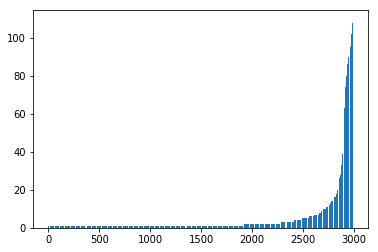

In [61]:
plt.bar(X, tambar, label = 'Grupos basicos')
plt.show()


In [62]:
#obtener los grupos que tengan mas de 10 tweets

similares = []
for e in grordenado:
    if len(e) >= 50:
        similares.append(e)
#print(tambar)
print(len(similares))

92


# AGRUPANDO POR SIMILARIDAD

Ahora lo que haremos será usar un algoritmo de clasificación de la libreria sklearn , que se llama KMEANS, para crear centroides y que los tweets se ubiquen alrededor de estos, arreglaremos un poco los datos para que sean distancias minimas, asi que vamos a invertir los valores de que hay, tomaremos 1 y restaremos la similaridad que existe, para que ahora los tweets mas parecidos sean los que menos valor tienen, tomando esto como los que estan mas cerca unos de otros.

In [21]:
FixMtzSimilaridad = np.zeros((NroTweets, NroTweets))

for i in range(NroTweets):
    for j in range(NroTweets):
        
        FixMtzSimilaridad[i][j] = 1 - Msimilaridad[i][j]
        
print(FixMtzSimilaridad)

[[0.         0.22063455 0.09673103 ... 0.50521114 0.37711245 0.22898831]
 [0.22063455 0.         0.15307096 ... 0.45939511 0.42483437 0.3016399 ]
 [0.09673103 0.15307096 0.         ... 0.3538989  0.33026997 0.16312128]
 ...
 [0.50521114 0.45939511 0.3538989  ... 0.         0.43907638 0.29374581]
 [0.37711245 0.42483437 0.33026997 ... 0.43907638 0.         0.42420261]
 [0.22898831 0.3016399  0.16312128 ... 0.29374581 0.42420261 0.        ]]


Se hará un agrupamiento de tweets, por su similaridad con ayuda del algoritmo [KMeans ](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

nos basaremos en los modelos de [super data science](https://www.superdatascience.com/machine-learning/) para poder escoger un buen número de centroides y realizar las respectivas graficas

In [22]:

#vamos a calcular cual es mejor numero de cluster para crear dentro del modelo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, precompute_distances= False)
    kmeans.fit(FixMtzSimilaridad)
    wcss.append(kmeans.inertia_)


Ahora vamos a graficar para escoger un buen número de clusters

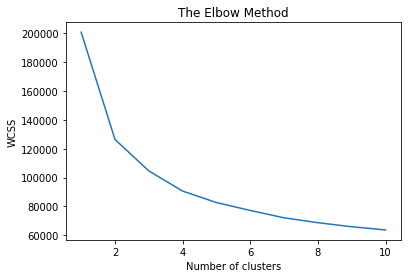

In [23]:
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Para este caso, y con esta cantidad de tweets podemos encontrar que hay mayor inercia usando pocos centroides, por tal motivo se va escoger el valor de 2

In [32]:


kmeans = KMeans(n_clusters = 3 ,random_state = 42, precompute_distances = False).fit(FixMtzSimilaridad)
y_kmeans = kmeans.fit_predict(FixMtzSimilaridad)


Ahora tenemos en el metodo labels_ , para cada tweet en que grupo esta, como podemos ver hay 8 grupos, y 3660 tweets y el primer tweet esta en el grupo 6

In [33]:
print("Cantidad de grupos existentes: ",len(set(kmeans.labels_)))
print("Cantidad de tweets: ", len(kmeans.labels_))
print("Grupo del primer Tweet: ",kmeans.labels_[0])

Cantidad de grupos existentes:  3
Cantidad de tweets:  3660
Grupo del primer Tweet:  0


In [34]:
print(kmeans)
print(y_kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances=False,
    random_state=42, tol=0.0001, verbose=0)
[0 0 0 ... 2 2 0]


Ahora vamos a visualizar los grupos que tenemos para ver que tan bien quedaron nuestros grupos, para esto primero importamos la libreria matplotlib.

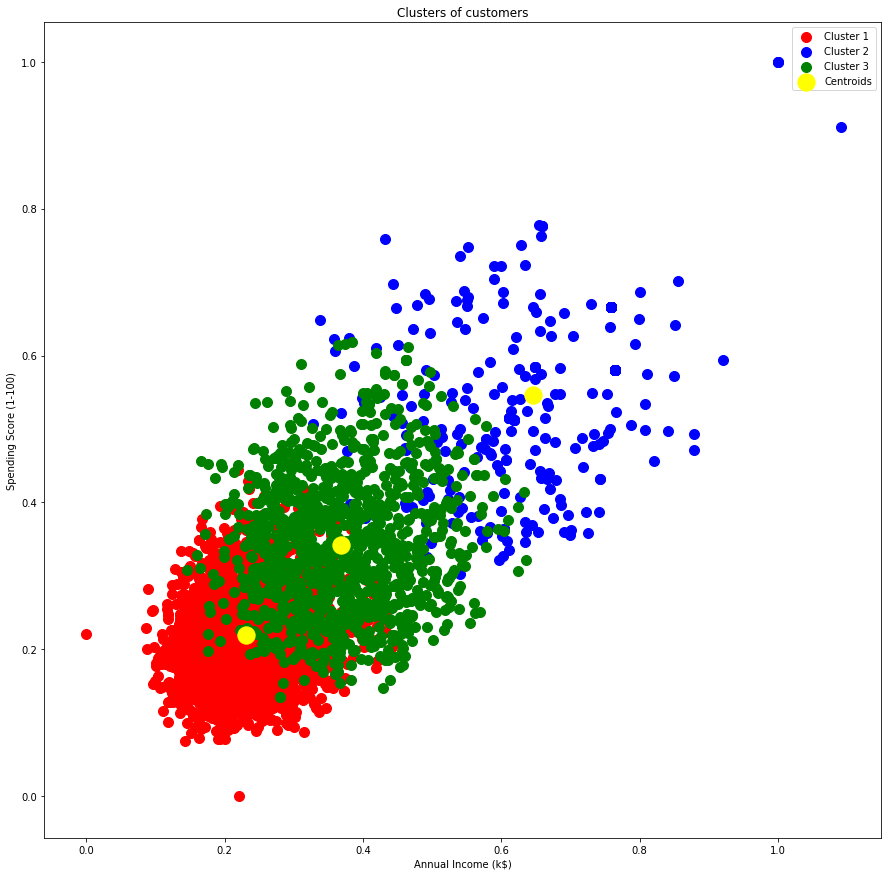

In [35]:

plt.figure(figsize  = (15,15))

# Visualising the clusters
plt.scatter(FixMtzSimilaridad[y_kmeans == 0, 0], FixMtzSimilaridad[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(FixMtzSimilaridad[y_kmeans == 1, 0], FixMtzSimilaridad[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(FixMtzSimilaridad[y_kmeans == 2, 0], FixMtzSimilaridad[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
#plt.scatter(FixMtzSimilaridad[y_kmeans == 3, 0], FixMtzSimilaridad[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
#plt.scatter(FixMtzSimilaridad[y_kmeans == 4, 0], FixMtzSimilaridad[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [36]:
grupos = kmeans.labels_ # obtengo una lista del tamaño de los tweets 
#que indica a que grupo pertenece cada tweet

grupo1 = []
grupo2 = []
grupo3 = []
grupo4 = []

for i in range(len(grupos)):
    
    if grupos[i] == 0:
        grupo1.append(i)
    elif grupos[i] == 1:
        grupo2.append(i)
    elif grupos[i] == 2:
        grupo3.append(i)
    elif grupos[i] == 3:
        grupo4.append(i)


Analizaremos un poco el grupo1 para ver la tematica de estos tweets

In [39]:

print(len(grupo1))
for e in range(100,110):
    print(tweets[grupo1[e]])
    print('--')

2198
Después de ver #ElPaísDeLosJóvenes de @CaracolTV, quedé indeciso si votar por @petrogustavo o @DeLaCalleHum#YoVotoEnElExterior #ColombianosEnElExterior. #Elecciones2018 #EleccionesColombia #PilasConElVoto
--
Inclusive sin publico pero EN DIRECTO, por eso lo de #ElPaisDeLosJovenes no me llamo la atención.  https://twitter.com/bluradioco/status/986938714143232000 …
--
Todo seria mas fácil si @petrogustavo @sergio_fajardo @DeLaCalleHum se les diera la gana de unirse #ElPaisDeLosJovenes pero ni paz hay en esto.  https://twitter.com/petrogustavo/status/986795167972720640 …
--
Midan el nivel de la SOBERBIA, ARROGANCIA y DESPRECIO de los Obradoristas Maduros. Es el tipo de personas que llama tigres López Obrador.El mismo que dice que Venezuela es el cielo. #TodosSomosMéxico#AMLONo#ElPaisDeLosJovenes#NoSeamosIndiferentes#LoMismoDecíanEnVenezuela pic.twitter.com/c6PKaO9d7z
--
¿? Pero en #ElPaísDeLosJóvenes dijo totalmente lo opuesto a la familia de la forma en la que la plantea el @soycons

veo mucha basura, pero casi siempre son de los candidatos en contra de petro.

In [44]:
print(len(grupo2))
for e in range(200,210):
    print(tweets[grupo2[e]])
    print('--')

307
#ElPaisDeLosJovenes ha pensado en dar ayudas a las protectoras de animales?
--
Muy conectada #ElPaísDeLosJóvenes
--
#ElPaisDeLosJovenes los que pagan para llegar, llegan a robar. <Emoji: Ok hand sign><Emoji: Ok hand sign><Emoji: Ok hand sign>
--
#ElPaísDeLosJóvenes  https://twitter.com/Pelicolombianas/status/975817953957548034 …
--
#ElPaisDeLosJovenes  pic.twitter.com/afoTJO27yu
--
@Randres005 <Emoji: Raised hand with fingers splayed (light skin tone)> #SePuede #FajardoPresidente #ElPaísDeLosJóvenes
--
#ElPaisDeLosJovenes  pic.twitter.com/mUFGuoVsEA
--
"Los que pagan por llegar, llegan a robar" <Emoji: Clapping hands sign><Emoji: Clapping hands sign>#ElPaisDeLosJovenes #Fajardo
--
#ElPaisDeLosJovenes  pic.twitter.com/7EQfsAngtw
--
Es en las urnas que debemos acabar con los políticos tradicionales que se nos roban las oportunidades. Que prometen inviables y no cumplen.#ElPaísDeLosJóvenes#SePuede#FajardoPresidente
--


In [42]:
print(len(grupo3))
for e in range(300,310):
    print(tweets[grupo3[e]])
    print('--')

1155
Al "Drogadicto" no se le debe atacar, primero debemos prevenir que entre a ese mundo, y si ya esta en el, debemos darle todas las herramientas para salir de allí sin necesidad de discriminarlo. #FajardoPresidente #ElPaisDeLosJovenes
--
¡Esto! <Emoji: Ok hand sign>¡5 razones por la que votaré por Fajardo!#ElPaisDeLosJovenes  https://twitter.com/JuanPsicologiaa/status/984646842838331392 …
--
#ElPaísDeLosJóvenes somos 12 millones de jóvenes aptos para votar, perfectamente podríamos elegir el presidente, el problema es que estamos divididos en 3 candidatos, mientras que los 18 millones restantes solo tienen 2 candidatos y lo peor solo el 40% ejerce su derecho. :(
--
Amigos, si a la coalición! Fajardo y de la calle #ElPaísDeLosJóvenes
--
Muy de acuerdo con esta apreciación #FajardoPresidente #ElPaísDeLosJóvenes  pic.twitter.com/iKXlWt7hfZ
--
@CaracolTV @sergio__fajardo Ajajaj Muchas gracias, es importante que todos revisemos los temas que generarán cambios  en nuestro futuro <Emoji: Ne

In [43]:
print(len(grupo4))
for e in range(0,0):
    print(tweets[grupo4[e]])
    print('--')

0


text rank, gensim, rake, obtengo keywords
limpieza
en spacy reconocimiento de nombres y adjetivos


skipgram